In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

The fit takes place between the first record where the >0.3 bin is less than 65535 and the last record where pm2.5 > 25 ug/m^3. The experiment must start with a high enough concentration of aerosols for the >0.3 bin to be 65535.

**IMPORTANT!!** When the air cleaner is turned on the >0.3 concentration may temporarily drop below 65535 before going back up. Edit the csv to delete the records prior to >0.3 being at 65535 or else the CADR calculation will not work correctly.

<AxesSubplot:xlabel='time'>

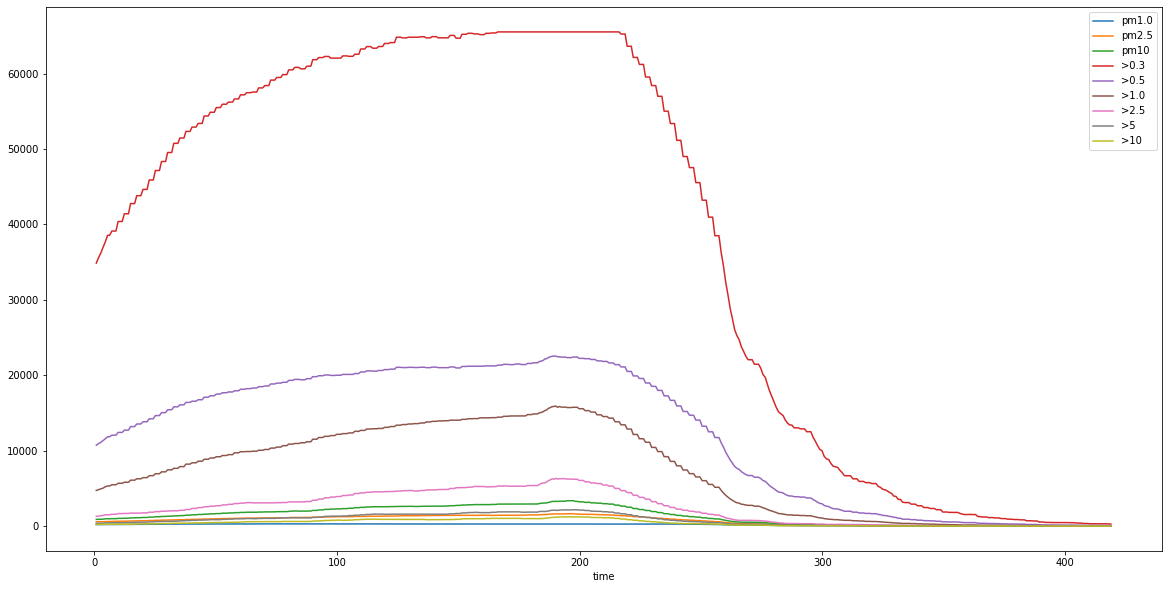

In [356]:
#df = pd.read_csv('data/20220623_4_ArcticP14_4_ikea_100_pwr.csv')
#df = pd.read_csv('data/20220623_2_iPPC3000_2_ikea_100_pwr.csv')
#df = pd.read_csv('data/20220623_2_iPPC3000_2_ikea_66_pwr.csv')
#df = pd.read_csv('data/20220623_Levoit400s_4_spd.csv')
#df = pd.read_csv('data/20220623_ACH_vd.csv')
#df = pd.read_csv('data/20220624_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data/20220624_4_A12x25_3_Starkvind_100_pwr_0_days.csv')
#df = pd.read_csv('data/20220624_4_A12x25_3_Starkvind_100_pwr_44_days.csv')
#df = pd.read_csv('data/20220626_2_NF-P12_redux1700PWM_2_Starkvind_100_pwr.csv')
#df = pd.read_csv('data/20220701_LaskoB20201_4_Filtrete1900_1_spd.csv')
#df = pd.read_csv('data_smoke/20220707b_Levoit400s_4_spd.csv')
df = pd.read_csv('data/20220705a_Levoit400s_4_spd.csv')


# plot the original data
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

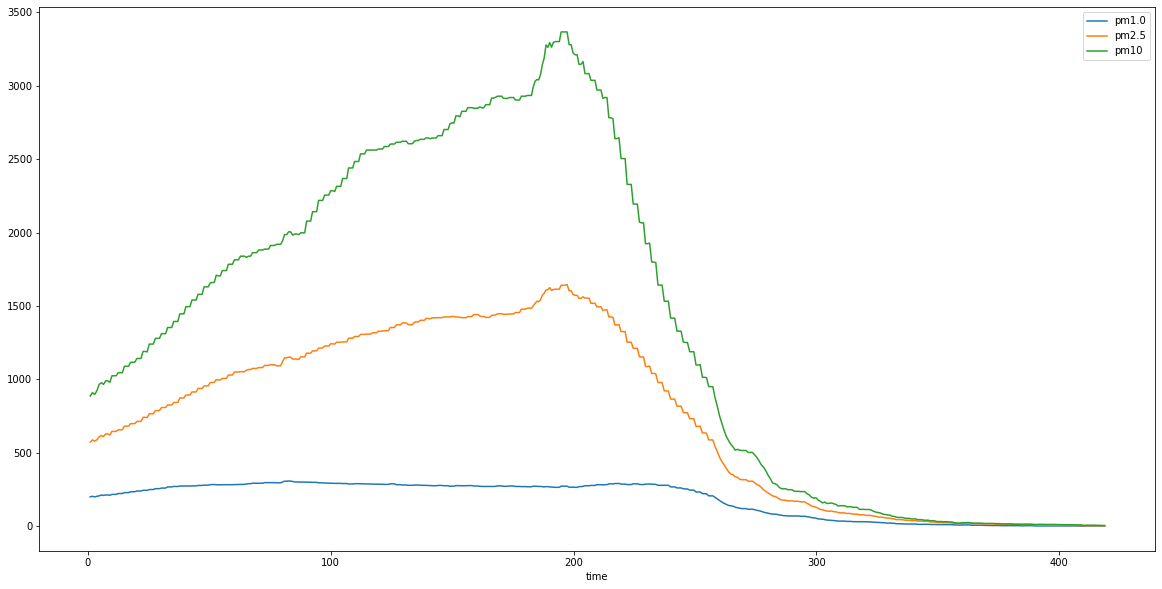

In [357]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()

# plot only pm1.0, pm2.5, and pm10
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

In [358]:
i = df.idxmax()['pm2.5']
print(df['pm2.5'][i])
print(df['pm2.5'].max())
print(df.time[i])
j = df[df.time > df.time[i] + 5].index[0]
print(df.time[j])

1646
1646
197.35233426094052
203.10351538658145


In [359]:
# begin window search at pm2.5 max
pm25_max_idx = df.idxmax()['pm2.5']
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx)
df.index = df.index - df.index[0]
df.time = df.time - df.time[0]

end_start_search = df[df['>0.3'] < 65535].index[0]

def test_fit(df):
    # cut all values after pm2.5 gets to about 25, they have an outsized impact on fit after converting to log
    lt25_iloc = df[df['pm2.5'] < 25].index[0]
    df = df[:lt25_iloc]

    # see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
    C_bgd = 0
    C_pt0 = df['pm2.5'][df.index[0]]

    ## logarithmic function
    def func(t, ACH):
        # divide by 3600 to convert seconds to hours
        return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

    def linear_func(t, ACH):
        return np.log(C_pt0) - ACH * t / 3600

    popt, pcov = curve_fit(linear_func, df.time, np.log(df['pm2.5']))
    ACH = popt[0]
    stddev = np.sqrt(np.diag(pcov)[0])
    return (ACH, stddev)

fits = []
for i in range(end_start_search):
    df_pm25 = df[['time','pm2.5']].copy()

    if i != 0:
        df_pm25 = df_pm25.tail(-i)
        # adjust times according to new t0 after tail was run
        df_pm25.time = df_pm25.time - df_pm25.time.iloc[0]
        df_pm25.index = df_pm25.index - df_pm25.index[0]
    
    ACH, stddev = test_fit(df_pm25)
    fits.append((i, ACH, stddev))
df_fits = pd.DataFrame(fits, columns=['i', 'ACH', 'stddev'])
j = df_fits.idxmin()['stddev']
print('time: {}'.format(df.time[df_fits.i[j]]))
print('ACH: {}'.format(df_fits.ACH[j]))
print('stddev: {}'.format(df_fits.stddev[j]))


time: 18.899308204650907
ACH: 103.28756640532912
stddev: 0.4863120118616199


<AxesSubplot:xlabel='time'>

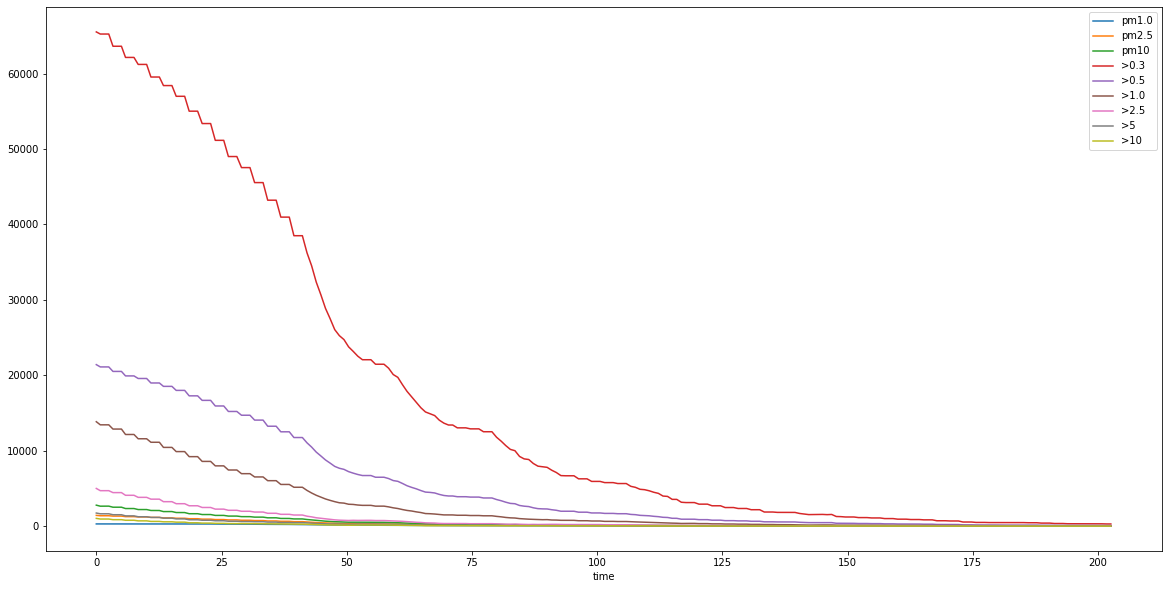

In [360]:
## cut off all records before >0.3um reached 65535, looking to start after the drop from 65535
#drop_start_idx = df[df['>0.3'] == 65535].index[0]
#if drop_start_idx != 0:
#    df = df.tail(-drop_start_idx)
#df.index = df.index - df.index[0]
#
## cut off all records before >0.3um was below 65535, sensor values may be incorrect before then since it's at max 16-bit unsigned int
#drop_start_idx = df[df['>0.3'] < 65535].index[0]
#if drop_start_idx != 0:
#    df = df.tail(-drop_start_idx)
## adjust times according to new t0 after tail was run
#df.time = df.time - df.time.iloc[0]
#df.index = df.index - df.index[0]
#
## plot the data after pruning all records prior to when >0.3um was below 65535
#df.set_index('time').plot(kind='line', figsize=(20,10))

#pm25_max_idx = df.idxmax()['pm2.5']
## 5s after max pm2.5 (give the fans a moment to spin up)
#drop_start_idx = df[df.time > df.time[pm25_max_idx] + 7].index[0]
#if drop_start_idx != 0:
#    df = df.tail(-drop_start_idx)
#df.index = df.index - df.index[0]
#df.time = df.time - df.time[0]

drop_start_idx = j
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx)
# adjust times according to new t0 after tail was run
df.time = df.time - df.time.iloc[0]
df.index = df.index - df.index[0]


df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

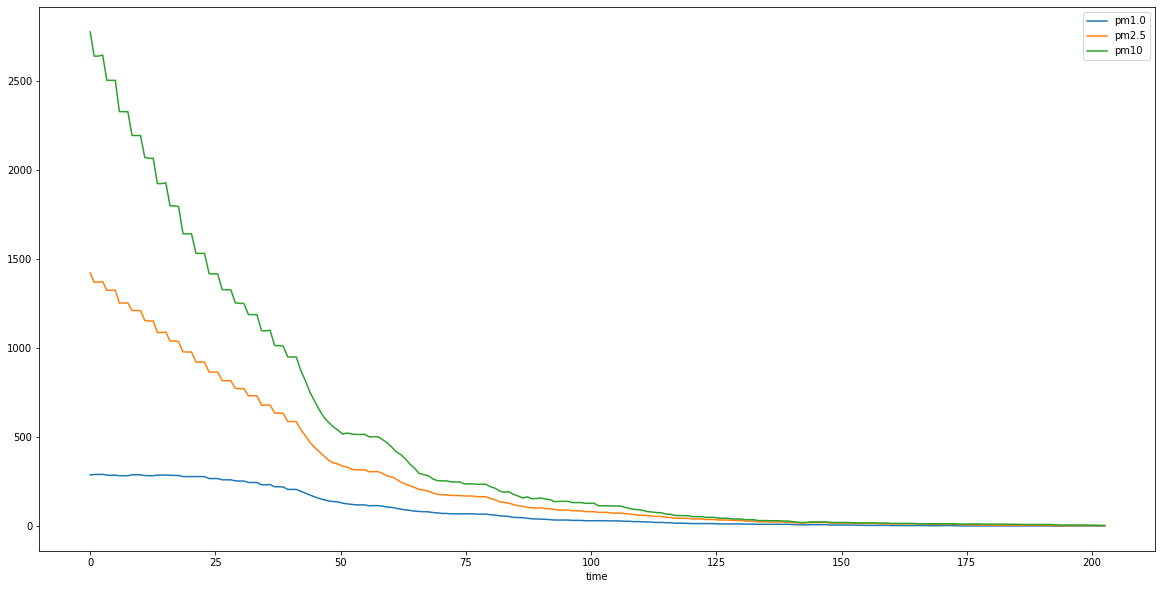

In [361]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()

# plot only pm1.0, pm2.5, and pm10
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

ACH: 103.28756640532912
stddev: 0.4863120118616199


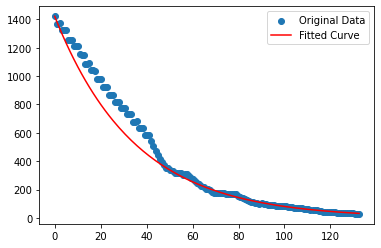

In [362]:
df_pm25 = df[['time','pm2.5']].copy()

# cut all values after pm2.5 gets to about 25, they have an outsized impact on fit after converting to log
lt25_iloc = df_pm25[df_pm25['pm2.5'] < 25].index[0]
df_pm25 = df_pm25[:lt25_iloc]

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
C_bgd = 0
C_pt0 = df_pm25['pm2.5'][df.index[0]]

## logarithmic function
def func(t, ACH):
    # divide by 3600 to convert seconds to hours
    return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

def linear_func(t, ACH):
    return np.log(C_pt0) - ACH * t / 3600

popt, pcov = curve_fit(linear_func, df_pm25.time, np.log(df_pm25['pm2.5']))
print('ACH: {}'.format(popt[0]))
print('stddev: {}'.format(np.sqrt(np.diag(pcov))[0]))
plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

For this next part don't forget to change ACH_vd (ACH due to ventilation and deposition) and V_r (Volume of room/chamber) to match your values.

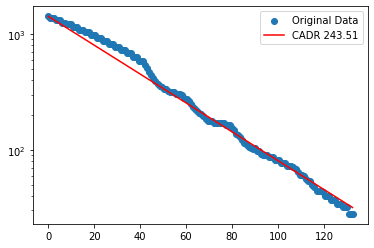

In [363]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd = 3.658926048639792
ACH_f = popt[0] - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()